In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats 

from sklearn.preprocessing import MinMaxScaler #Min max Scaler for normalization of data to range [0,1]
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge #Importing the linear regression models
from sklearn.metrics import mean_squared_error #For evaluation of the models 
from sklearn.model_selection import train_test_split


In [2]:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True) 

In [35]:
X = pd.DataFrame(california_housing.data)
y = pd.DataFrame(california_housing.target)
number_of_features = len(california_housing.feature_names)
feature_names = california_housing.feature_names

In [34]:
X.head()


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [24]:
y.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


Dataset size (N) = 17000,
Features (D) = 8. <br>
#Predict median_house_value. 

In [16]:
X.isnull().sum()


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

#No null values, clean dataset

#Visualizations of the data to see some patterns

<h3> 1. Histograms to see the distributions of every feature </h3>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

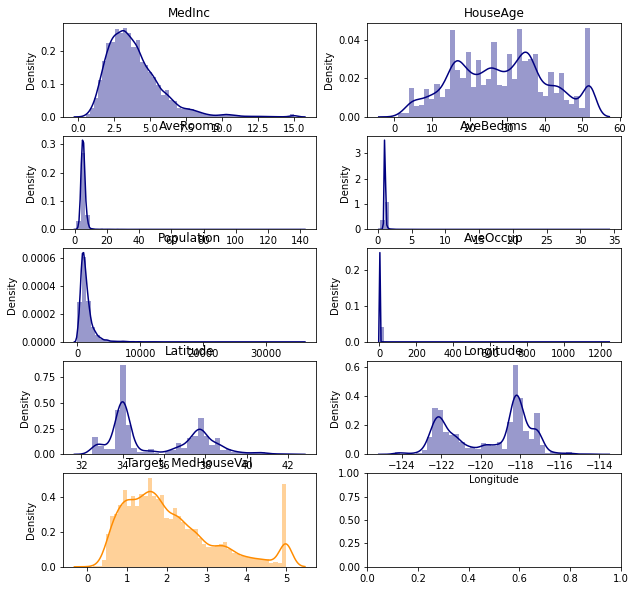

In [37]:
fig = plt.figure(figsize=(10, 10))
fig.subplots(number_of_features//2+1, ncols=2)
for feat_i in range(number_of_features): #The histograms of the features
    ax = plt.subplot(number_of_features//2+1,2, feat_i+1)
    plt.title(feature_names[feat_i]) 
    sb.distplot(X.iloc[:,feat_i], color = "navy") 
ax = plt.subplot(number_of_features//2+1,2, feat_i+2)
plt.title("Target: MedHouseVal" ) 
sb.distplot(y, color = "darkorange") #The histograms of the target variable
plt.show()

<h2>The histograms of the features are very interesting because they show some known distributions. <br><br>
MedInc has right-skewed (positive skewed) distribution. This implies bigger mean than mode.<br><br>
HouseAge has distribution with multiple peaks. In this case it might be a multimodal distribution known as a Plateau Distribution when there are more than a few peaks close together.<br><br>
Latitude and Longitude both have bimodal distribution (it has two peaks). <br><br>
The target has an edge peak distribution, where there is an additional, out of place peak at the edge of the distribution. This usually means that you’ve plotted (or collected) your data incorrectly, unless you know for sure your data set has an expected set of outliers. <br><br>
Other features all have Gamma distribution, just with different scale.</h2>


<br><br><h3> 2. Scatterplots to see the corrlation between features </h3>

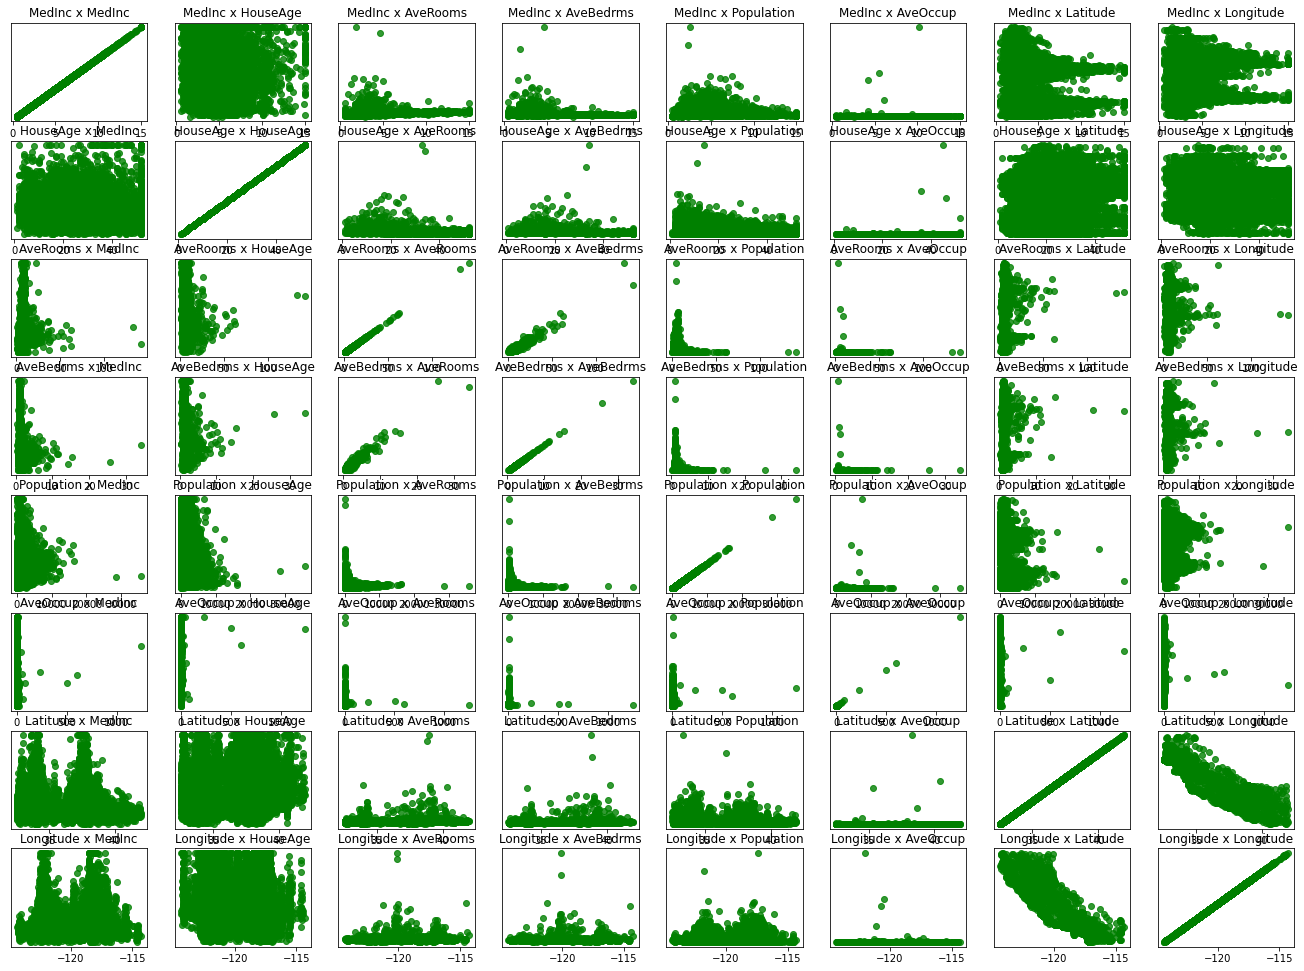

In [45]:
fig = plt.figure(figsize=(23, 17))
fig.subplots(nrows=number_of_features, ncols=number_of_features)
for feat_i in range(number_of_features): #We go over all pairs of features (3x3 in this case)
    for feat_j in range(number_of_features):  
        ax = plt.subplot(number_of_features,number_of_features,number_of_features*feat_i + feat_j+1)
        plt.scatter(X.iloc[:,feat_i], X.iloc[:, feat_j], alpha=.8, color="green") 
        plt.yticks(())
        plt.title(feature_names[feat_i]+" x "+feature_names[feat_j])
plt.show()

Quite visible are the dependencies between some features forming linear dependence, some clusters or peaked distribution.

<br><br><h3> 3. Scatterplots to see the correlation between features and Target </h3>

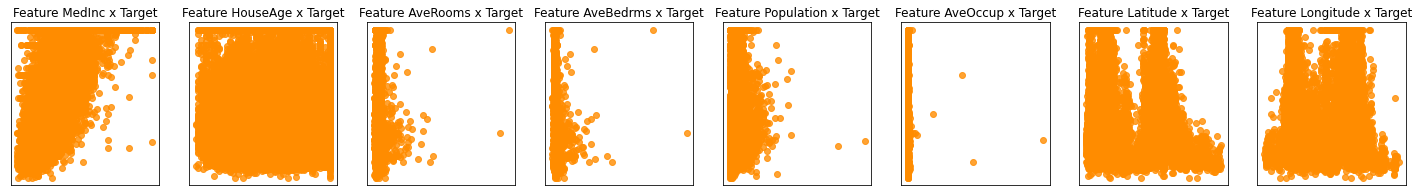

In [49]:
fig = plt.figure(figsize=(25, 3))
fig.subplots(ncols=number_of_features)
for feat_i in range(number_of_features): 
    ax = plt.subplot(1 ,number_of_features, feat_i+1)
    plt.scatter( X.iloc[:,feat_i], y,  alpha=.8, color="darkorange") 
    plt.xticks(())
    plt.yticks(())
    plt.title("Feature "+feature_names[feat_i]+" x Target")
plt.show()

<br><br><h3> 4. Target KDE joint plots. </h3>

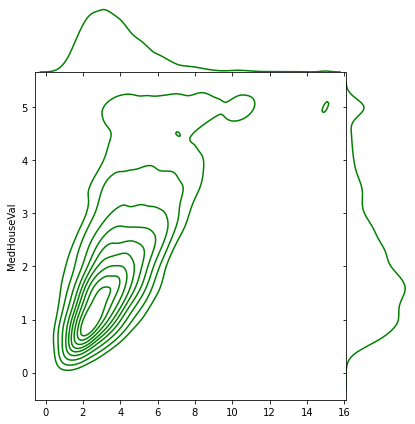

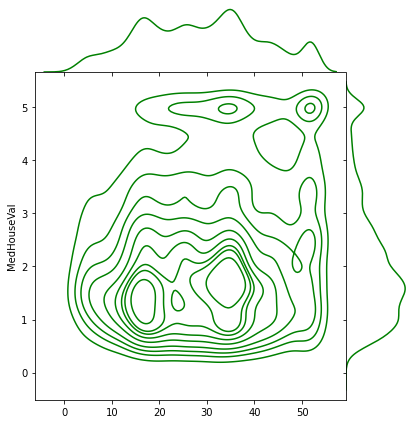

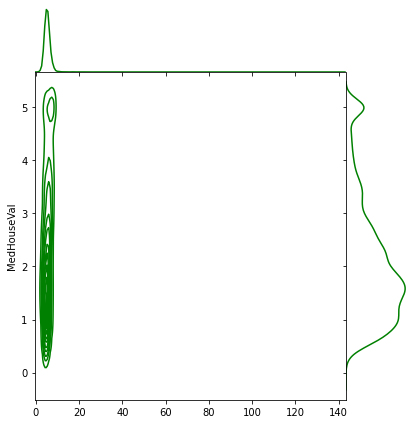

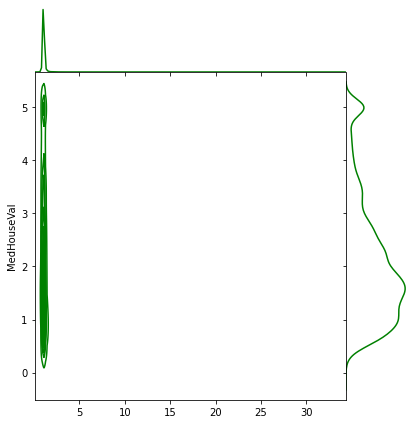

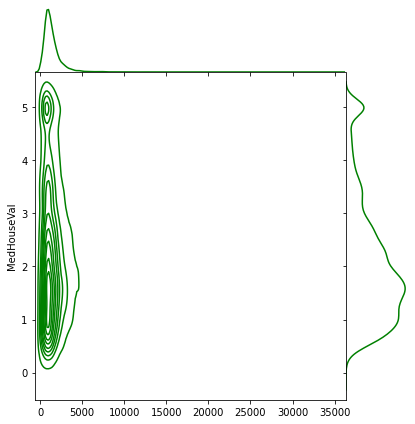

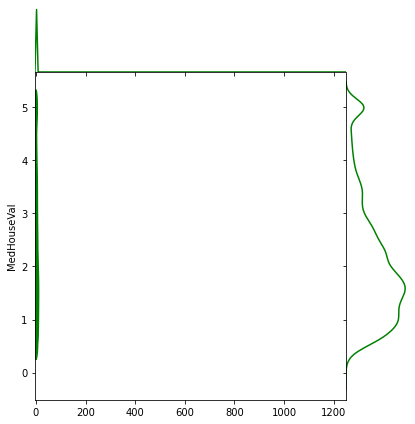

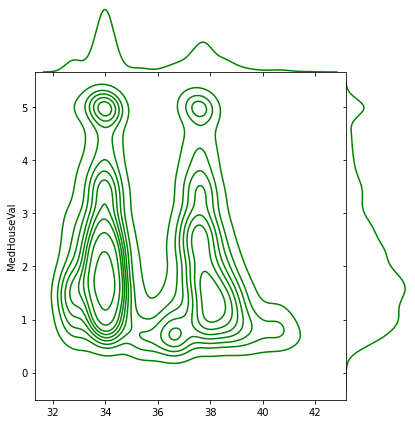

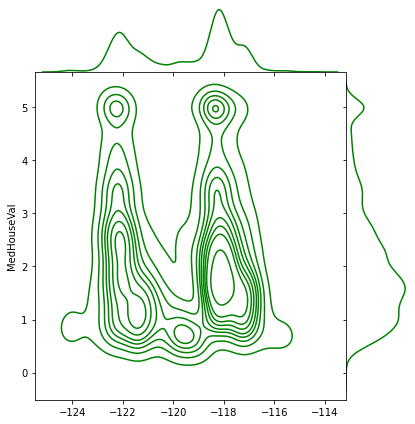

In [62]:
for feat_i in range(number_of_features):
    sb.jointplot(x=np.array(X.iloc[:,feat_i]), y=y.iloc[:,0], kind="kde", space=0, color="g")
plt.show()

<br><br><h3> 5. Correlation matrix </h3>

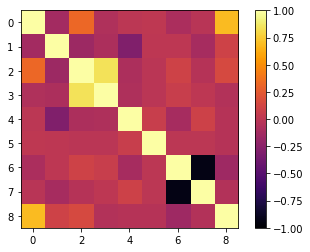

In [65]:
correlation_matrix = np.ones((number_of_features +1 ,number_of_features +1))
for i in range(number_of_features): #The first 3x3 part of the matrix represents the feature correlations
    measure = X.iloc[:,i]
    for j in range(number_of_features):
        measure2 = X.iloc[:,j]
        corr, _ = stats.pearsonr(measure, measure2)
        correlation_matrix[i][j] = corr
for i in range(number_of_features): #The last column and row represent the feature to target variable correlations
    j = number_of_features
    measure = X.iloc[:,i]
    measure2 = y
    corr, _ = stats.pearsonr(measure, measure2)
    correlation_matrix[i][j] = corr
    correlation_matrix[j][i] = corr
plt.figure()
plt.imshow(correlation_matrix, cmap = "inferno", vmin=-1, vmax=1) #We can draw the matrix using imshow
plt.colorbar()
plt.show()

<h3>Strong correlation between features (0,8), (2,3), (0,2).

<h2>Scaling the features to be in rang [0,1]

In [66]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

#Regression models

<h2> 1. Regression using the standard Linear Regression model

In [67]:
reg = LinearRegression().fit(X_train, y_train)
print("Coefficients W")
print(reg.coef_)
print("Intercept W0")
print(reg.intercept_ )
y_pred = reg.predict(X_test)
print("Error")
print(mean_squared_error(y_test, y_pred))

Coefficients W
[[  6.46451636   0.49377527 -17.22309506  26.26475839  -0.02767764
   -4.1877334   -3.93843078  -4.35422728]]
Intercept W0
[3.64010783]
Error
0.5305677824766752


**We can see the coefficients are big numbers which variations can be big causing changes in the model with new coming data.**

 <h2> 2. Regression using the Ridge Regression model

In [68]:
reg = Ridge(alpha=1).fit(X_train, y_train)
print("Coefficients W")
print(reg.coef_)
print("Intercept W0")
print(reg.intercept_ )
y_pred = reg.predict(X_test)
print("Error")
print(mean_squared_error(y_test, y_pred))

Coefficients W
[[ 5.58798988  0.50340364 -1.46588     6.11300155 -0.04889709 -2.2967199
  -4.15779262 -4.52363121]]
Intercept W0
[3.93300239]
Error
0.527137808285123


**With Ridge Regression, coefficients are modeled with Normal distribution with mean=0. This implies scaling the coefficients and more zero-centered values to be present. **

<h2> 3. Regression using the Lasso Regression model

In [69]:
reg = Lasso(alpha = 0.1).fit(X_train, y_train)
print("Coefficients W")
print(reg.coef_)
print("Intercept W0")
print(reg.intercept_ )
y_pred = reg.predict(X_test)
print("Error")
print(mean_squared_error(y_test, y_pred))

Coefficients W
[ 0.26920081  0.          0.         -0.         -0.         -0.
 -0.         -0.        ]
Intercept W0
[2.00654469]
Error
1.2585434457041687


With Lasso Regression, coefficients are modeled with Laplace distribution with mean=0. The difference with Ridge regularization is visible. Here are present many 0 values in the coefficients, where in Ridge the params are close to zero, but rarely zero.

<h1>Concluded by MSE, Regression using the Lasso Regression model performs worse than the other two methods. This implies the output is dependable on all of the features and assigning zero weights is not a solution here!